In [ ]:
# from zipfile import ZipFile
# with ZipFile('/content/drive/MyDrive/CNN/archive.zip', 'r') as zipObj:
#    zipObj.extractall('/content/drive/MyDrive/CNN/Imagecap')

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
import os
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16 ,preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np
import pickle
from tensorflow.keras.layers import Dense, Dropout, LSTM,Input ,Embedding,add
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model

In [5]:
INPUT_PATH = '/content/drive/MyDrive/CNN/ImageCaption'

In [28]:
model = VGG16()
model = Model(inputs = model.inputs, outputs = model.layers[-2].output)
print(model.summary())

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [ ]:
model.output.shape

TensorShape([None, 4096])

In [29]:
model.save('feature_extractor.h5')

In [6]:
from tqdm import tqdm

Image feature Extraction

In [ ]:
features ={}
IMAGE_PATH = '/content/drive/MyDrive/CNN/Imagecap/Images'
for img_name in tqdm(os.listdir(IMAGE_PATH)):
  img_file = os.path.join(IMAGE_PATH, img_name)
  img = load_img(img_file,target_size=(224,224))
  img_arr = img_to_array(img)
  img_arr = img_arr.reshape((1,img_arr.shape[0],img_arr.shape[1],img_arr.shape[2]))
  image = preprocess_input(img_arr)
  feature = model.predict(image,verbose =0)
  img_id = img_name.split('.')[0]
  features[img_id] = feature 

In [ ]:
pickle.dump(features,open(os.path.join('/content/drive/MyDrive/CNN/Imagecap','features.pkl'),'wb'))

In [ ]:
len(features)

31751

Caption mapping

In [ ]:
with open('./captions.txt') as f:
  next(f)
  caption_doc = f.read()

In [ ]:
mapping ={}
for line in tqdm(caption_doc.split('\n')):
  tokens = line.split(',')
  image_id , caption = tokens[0],tokens[1:]
  image_id = image_id.split('.')[0]
  if image_id not in mapping:
    mapping[image_id] =[]
  caption = ''.join(caption)
  mapping[image_id].append(caption)

100%|██████████| 158916/158916 [00:00<00:00, 619300.53it/s]


In [12]:
def preprocess_caption(mapping):
  for key, captions in mapping.items():
    for i in range(len(captions)):
      line = captions[i]
      line = line.lower()
      line = line.replace('[^A-Za-z]','')
      line = line.replace('\s+',' ')
      line = 'startseq ' + ' '.join([word for word in line.split() if len(word)>1])+' endseq'
      captions[i] = line

In [10]:
len(mapping)

31751

In [ ]:
list1 = list(features.keys())
list2 = list(mapping.keys())
set1 = set(list1)
set2 = set(list2)

missing = list(sorted(set1 - set2))
added = list(sorted(set2 - set1))

print('missing:', missing)
print('added:', added)
len(added)

missing: []
added: ['', '1000092795', '10002456', '1000268201', '1000344755', '1000366164', '1000523639', '1000919630', '10010052', '1001465944', '1001545525', '1001573224', '1001633352', '1001773457', '1001896054', '100197432', '100207720', '1002674143', '1003163366', '1003420127', '1003428081', '100444898', '1005216151', '100577935', '1006452823', '100652400', '1007129816', '100716317', '1007205537', '1007320043', '100759042', '10082347', '10082348']


33

In [ ]:
for i in range(len(added)):
  key = added[i]
  del mapping[key]
len(mapping)

In [ ]:
preprocess_caption(mapping)

In [4]:
import numpy

In [21]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [22]:
len(all_captions)

158755

In [23]:
all_captions[:10]

['startseq five people walking with multicolored sky in the background endseq',
 'startseq four people walking through the sunset in clear blue skies endseq',
 'startseq four people walking with the sun setting behind them endseq',
 "startseq four silhouettes decorate the horizon 's sunset endseq",
 'startseq group of people walking as the sun sets endseq',
 'startseq man with black hair sits in restaurant with glass of beer endseq',
 'startseq man is sitting at table with drink endseq',
 'startseq man is sitting at table with beer endseq',
 'startseq dark-haired man sitting drinking endseq',
 'startseq old man having beer alone endseq']

In [24]:
max_len = max(len(caption.split())for caption in all_captions)
max_len

75

In [12]:
# tokenize the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) +1

In [30]:
with open('tokenizer.pkl', 'wb') as handle:
    pickle.dump(tokenizer, handle)

In [9]:
with open('mapping.pkl', 'rb') as handle:
    mapping = pickle.load(handle)
len(mapping)

31751

In [8]:
with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)
vocab_size = len(tokenizer.word_index) +1
vocab_size

18315

In [ ]:
mapping

Train Test Split

In [11]:
image_ids = list(mapping.keys())

In [12]:
split = round(len(mapping.keys())*0.9)

In [13]:
train = image_ids[:split]
test = image_ids[split:]

In [14]:
import numpy as np

In [15]:
def datagenerator(image_ids, mapping, features, max_len, vocab_size, tokenizer, batch_size):
  X1 , X2, y = [], [], []
  n=0
  while 1:
    for key in image_ids:
      n+=1
      captions = mapping[key]
      for caption in captions:
        seq = tokenizer.texts_to_sequences([caption])[0]
        for i in range(1,len(seq)):
          inseq , outseq = seq[:i],seq[i]
          inseq = pad_sequences([inseq],maxlen=max_len)[0]
          outseq = to_categorical([outseq],num_classes=vocab_size)[0]
          X1.append(features[key][0])
          X2.append(inseq)
          y.append(outseq)
      if n == batch_size:
        X1 , X2, y = np.array(X1),np.array(X2),np.array(y)
        yield [X1,X2],y
        n = 0
        X1 ,X2, y =[],[],[]

Model Creation

In [16]:
inputs1 = Input(shape = (4096,))
fe = Dropout(0.2)(inputs1)
fe = Dense(256,activation = 'relu')(fe)

In [25]:
inputs2 = Input(shape = (max_len,))
se1 = Embedding(vocab_size, 256, mask_zero = True)(inputs2)
se2 = Dropout(0.2)(se1)
se = LSTM(256)(se2)

In [26]:
decoder1 = add([fe,se])
decoder2 = Dense(256,activation = 'relu')(decoder1)
outputs = Dense(vocab_size,activation = 'softmax')(decoder2)

In [27]:
model = Model(inputs=[inputs1,inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')
plot_model(model ,show_shapes=True)

('Failed to import pydot. You must `pip install pydot` and install graphviz (https://graphviz.gitlab.io/download/), ', 'for `pydotprint` to work.')


Training the Model

In [28]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [ ]:
filepath=os.path.join('/content/drive/MyDrive/CNN/ImageCaption/weights',"weights-improvement-{epoch:02d}-{loss:.4f}.hdf5")
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

In [30]:
model.load_weights('weights-improvement-01-2.5599.hdf5')

In [ ]:
epochs = 5
batch_size = 32
steps = len(train) // batch_size
for i in range(epochs):
  generator = datagenerator(image_ids, mapping, features, max_len, vocab_size, tokenizer, batch_size)
  model.fit(generator, epochs=1,verbose=1,callbacks=callbacks_list,steps_per_epoch = steps)

893/893 [==============================] - ETA: 0s - loss: 2.5740
Epoch 1: loss improved from 2.59000 to 2.57403, saving model to /content/drive/MyDrive/CNN/ImageCaption/weights/weights-improvement-01-2.5740.hdf5
893/893 [==============================] - ETA: 0s - loss: 2.5599
Epoch 1: loss improved from 2.57403 to 2.55987, saving model to /content/drive/MyDrive/CNN/ImageCaption/weights/weights-improvement-01-2.5599.hdf5
 89/893 [=>............................] - ETA: 6:18 - loss: 2.5225

KeyboardInterrupt: ignored

In [ ]:
model.save(INPUT_PATH + '/img_cap_model.h5')

In [35]:
model = tf.keras.models.load_model('img_cap_model.h5')

In [31]:
def index_to_word(integer,tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word

In [32]:
def predict_caption(model, image,tokenizer,max_len):
  inseq = 'startseq'
  for i in range(max_len):
    sequence = tokenizer.texts_to_sequences([inseq])[0]
    sequence = pad_sequences([sequence],maxlen = max_len)
    yhat = model.predict([image,sequence],verbose = 0)
    index = np.argmax(yhat)
    word = index_to_word(index, tokenizer)
    if word == None:
      break
    if word == 'endseq':
      break
    inseq += " " + word
  return inseq

In [ ]:
from nltk.translate.bleu_score import corpus_bleu

In [ ]:
actual, predicted = [],[]
for key in tqdm(test):
  captions = mapping[key]
  y_actual = [caption.split() for caption in captions]
  actual.append(y_actual)
  y_pred = predict_caption(model, features[key],tokenizer,max_len)
  y_pred = y_pred.split()
  predicted.append(y_pred)

In [ ]:
with open(os.path.join('/content/drive/MyDrive/CNN/ImageCaption','actual_list.pkl'),'wb') as f:
  pickle.dump(actual,f)
with open(os.path.join('/content/drive/MyDrive/CNN/ImageCaption','predicted_list.pkl'),'wb') as f:
  pickle.dump(predicted,f)

In [ ]:
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
print("BLEU-3: %f" % corpus_bleu(actual, predicted, weights=(0.33, 0.33, 0.33, 0.33)))
print("BLEU-4: %f" % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

BLEU-2: 0.274373
BLEU-3: 0.038313
BLEU-4: 0.084357


In [64]:
def feature_extractor(img):
    extractor = tf.keras.models.load_model('./feature_extractor.h5')
    img_arr = img_to_array(img)
    img_arr = img_arr.reshape((1,img_arr.shape[0],img_arr.shape[1],img_arr.shape[2]))
    image = preprocess_input(img_arr)
    feature = extractor.predict(image,verbose =0)
    return feature

In [70]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    img = os.path.join('./Images', image_name)
    image = Image.open(img)
    new_image = image.resize((224,224))
    feature = feature_extractor(new_image)
    y_pred = predict_caption(model, feature, tokenizer, max_len)
    print('--------------------Predicted--------------------')
    print(y_pred.replace('startseq',''))
    plt.imshow(image)

--------------------Predicted--------------------
 two men are playing soccer


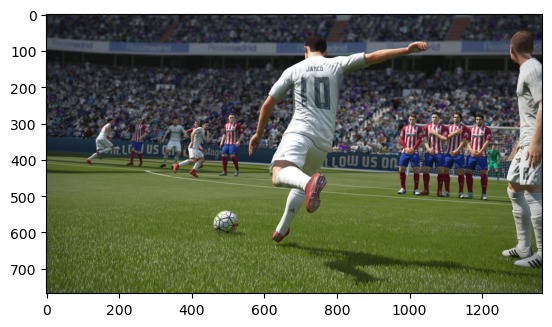

In [66]:
generate_caption('football.jpg')

--------------------Predicted--------------------
 man in blue shirt and black pants is jogging down the road


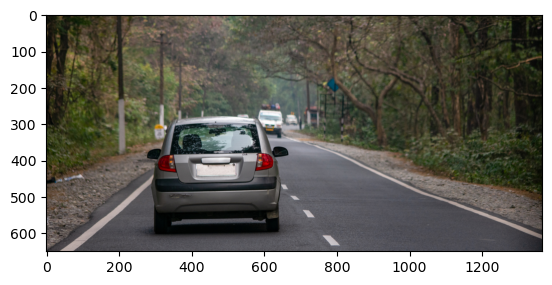

In [69]:
generate_caption('cardriving.jpg')

--------------------Predicted--------------------
 dog jumps over hurdle


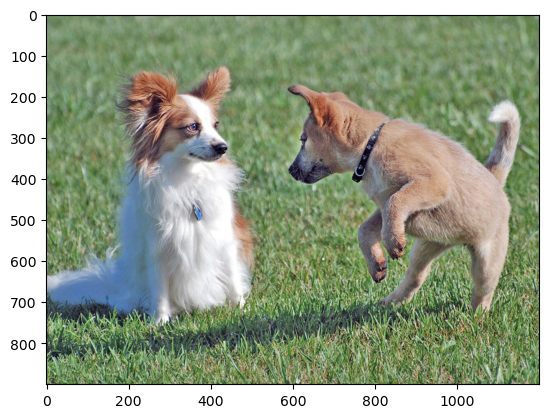

In [71]:
generate_caption('two-puppies-starting-to-play.jpg')